### Import packages

In [51]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

### Retrieve training data

In [52]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)

pickle_in = open('../data/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

### OLS One Time Function
- Function takes the X_train dataframe and y_train numpy array
- Returns the ols_model (model) and the ols model summary report (results)

In [53]:
def onetime_ols(X_train, y_train):
    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    model = ols_model.fit()
    results = model.summary()
    
    return model, results

### OLS Loop Function
- Function takes an X_train df and a y_train numpy array
- Also takes a run variable, used to track iterative loops through the function
- Returns x_chop, or the columns to be removed from the model based on thier p-values
- Also returns run_dict, a dictionary that captures parameters of the test

In [54]:
def ols_loop(X_train, y_train, run):

    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    est = ols_model.fit()
    results = est.summary()

    # Capture r2_adj 
    r2_adj = est.rsquared_adj

    # Load summary info into dataframe for processing
    results_as_html = results.tables[1].as_html()
    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'index':'feature'})
    results_df = results_df[1:]

    # Identify highest p-value in data set
    kill_cols = results_df[results_df['P>|t|'] == results_df['P>|t|'].max()]
    highest_p_col = kill_cols['feature'].values
    highest_p = kill_cols['P>|t|'].values

    # Remove feature with highest p-value
    X_chop = X_train.drop(columns=highest_p_col)

    # Capture values from test in dictionary
    run_dict = {'test_run': run, \
            'r2_adj': r2_adj, \
            'highest_feature': highest_p_col,\
            'highest_pval': highest_p[0]}
    
    return X_chop, run_dict

### View initial regression

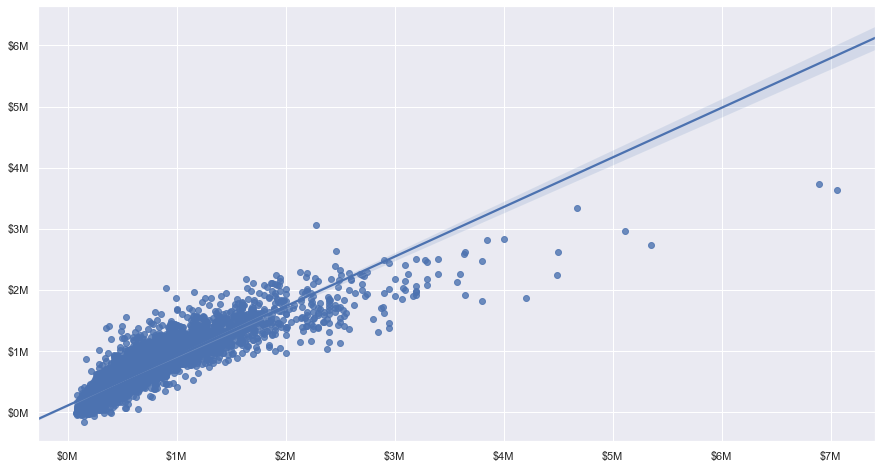

In [55]:
# Fit a multiple linear regression to the X and y train data
og_model, results = onetime_ols(X_train, y_train)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

# Review P>|t| values from generated results_df
results_df;

# Review r2 adjusted and other statistical results with the full summary
onetime_ols(X_train, y_train);

# Generate predicted prices from model
y_pred = og_model.predict()

# Plot predicted values
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

tr = sns.regplot(x=y_train, y=y_pred);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in tr.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in tr.get_xticks()/1000000]
tr.set_xticklabels(xlabels);
tr.set_yticklabels(ylabels);

# ## Look at the residuals as well, yellowbrick package for residual plots
# ### y_train - y_pred on y and then y_train on x axis

## Key takeaway:  The regression line looks good up to around 2.5 million.  At this point the predicted values are all above the actual values.  Hints at a polynomial relationship.

In [85]:
r2adj = og_model.rsquared_adj
print('Model\'s R2 adjusted value equals {}'.format(r2adj))

Model's R2 adjusted value equals 0.8119659862774881


### View initial residual plot

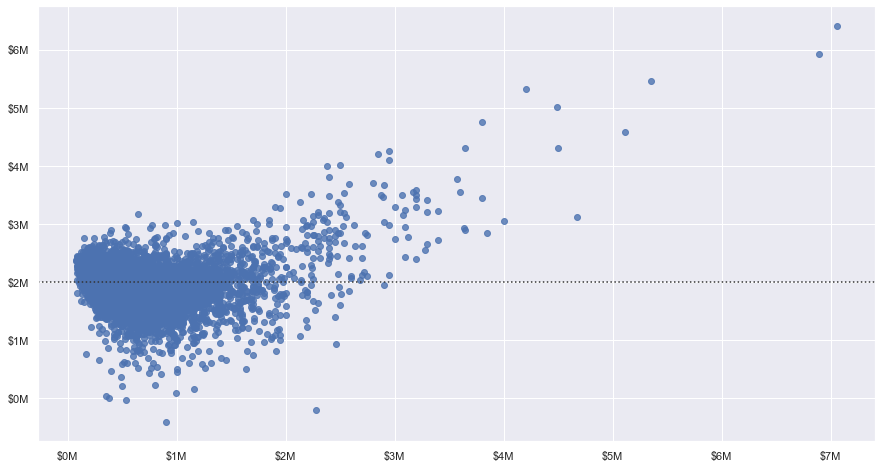

In [56]:
# Define x and y axis
xax = y_train
yax = y_train - y_pred

# Create sns graph
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

resid = sns.residplot(x=xax, y=yax);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in resid.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in resid.get_xticks()/1000000]
resid.set_xticklabels(xlabels);
resid.set_yticklabels(ylabels);

## This confirms the prior assumtion that this is a polynomial relationship.  The residuals steadily increase as the price increases after roughly 2.25 million dollars.

### Create a polynomial regression 

In [66]:
# Create polynomial regression using sklearn
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
poly_model = pol_reg.fit(X_poly, y_train);

In [67]:
# Generate predicted values
y_pred_poly = pol_reg.predict(X_poly)

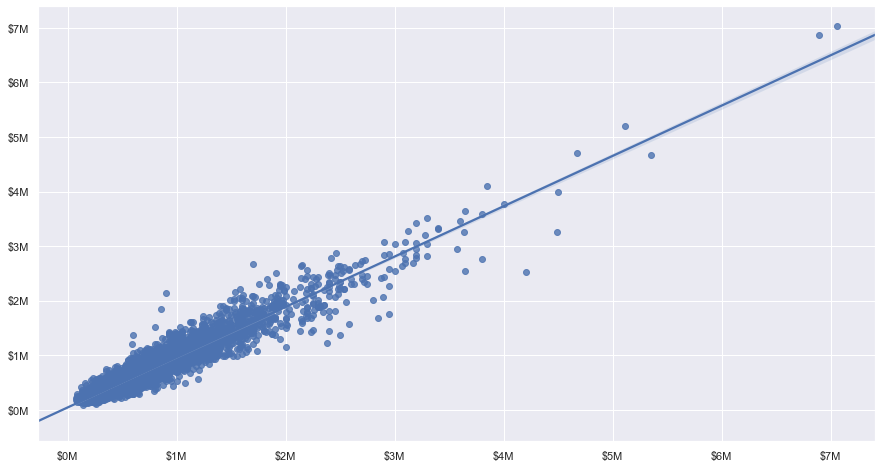

In [68]:
# Plot polynomial regression values
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

poly = sns.regplot(x=y_train, y=y_pred_poly);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in poly.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in poly.get_xticks()/1000000]
poly.set_xticklabels(xlabels);
poly.set_yticklabels(ylabels);

### Much nicer, let's take a look at the residuals

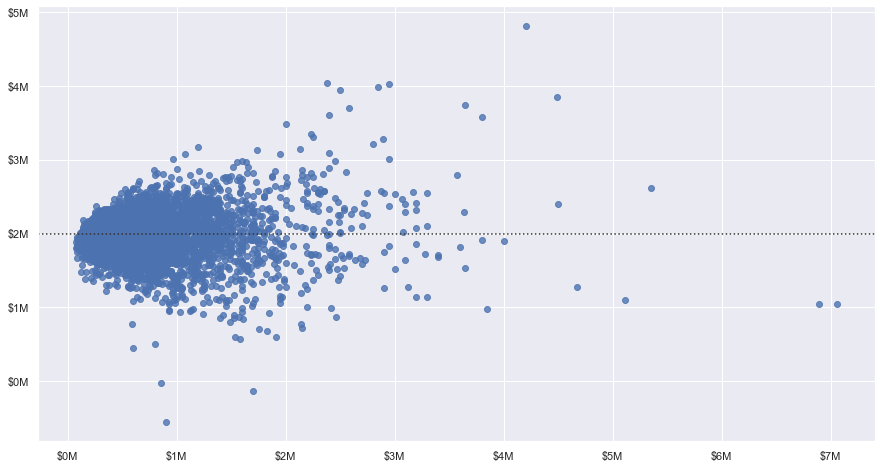

In [69]:
# Define x and y axis
xax = y_train
yax = y_train - y_pred_poly

# Create sns graph
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

resid_poly = sns.residplot(x=xax, y=yax);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in resid_poly.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in resid_poly.get_xticks()/1000000]
resid_poly.set_xticklabels(xlabels);
resid_poly.set_yticklabels(ylabels);

### This regression model is more appropriate.

In [88]:
poly_r2 = poly_model.score(X_poly, y_train)
print('The r2 for this regression equals {}, an improvement of {} compared to the linear regression'\
      .format(poly_r2, poly_r2 - r2adj))

The r2 for this regression equals 0.9194468621419986, an improvement of 0.1074808758645105 compared to the linear regression


Remove y_train outliers

In [6]:
# ind = np.argpartition(y_train, -1)[-2:]
# print(ind)
# print(y_train[ind])

# y_train2 = np.delete(y_train, 7358, 0)
# y_train2 = np.delete(y_train2, 2194, 0)
# x_train2 = X_train.drop(index=7358)
# x_train2 = x_train2.drop(index=2194)

[16147  7358]
[ 467000. 7060000.]


In [ ]:
# ind = np.argpartition(y_pred, -1)[-5:]
# print(ind)
# print(y_pred[ind])

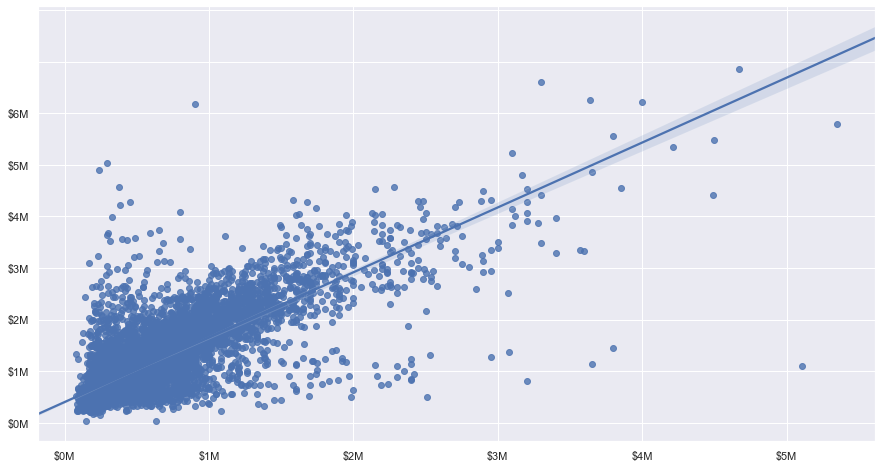

In [9]:
ot_est, results = onetime_ols(x_train2, y_train2)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

results_df;

onetime_ols(x_train2, y_train2)
y_pred1 = ot_est.predict(sm.add_constant(x_train2))

# Plot sns regplot
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

tr2 = sns.regplot(x=y_train2, y=y_pred1);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in tr2.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in tr2.get_xticks()/1000000]
tr2.set_xticklabels(xlabels);
tr2.set_yticklabels(ylabels);

### Loop for recursive feature elimination
Loops removes the highest p_value from an OLS regression and returns the R2 adjusted value and removed feature name

In [10]:
X_train.shape

(16149, 252)

In [11]:
run = 0
for run in range(1, 136):
    if run == 1:
        x_chop, run_dict = ols_loop(x_train2, y_train2, run)
        all_df = pd.DataFrame.from_dict([run_dict])
#         print('Run {} complete'.format(run))
    else:
        x_chop, run_dict = ols_loop(x_chop, y_train2, run)
        run_df = pd.DataFrame.from_dict([run_dict])
        all_df = pd.concat([all_df, run_df])

        # print('Run {} complete'.format(run))

In [15]:
all_df

,test_run,r2_adj,highest_feature,highest_pval
0,1,0.622692,[yr_built_1948],0.990
0,2,0.622716,[bathrooms_0.75],0.987
0,3,0.622740,[yr_built_1907],0.982
0,4,0.622763,[bedrooms_3],0.969
0,5,0.622787,[attic_1],0.966
...,...,...,...,...
0,131,0.622783,[yr_built_1927],0.073
0,132,0.622731,[yr_built_2002],0.068
0,133,0.622676,[yr_built_2005],0.072
0,134,0.622623,[yr_built_2007],0.085


### Review columns returned from ols loop analysis

### Review the recursive feature elimination and save to csv

In [18]:
rfe_results = results_df
rfe_results.to_csv('rfe_results.csv')
rfe_results

,feature,coef,std err,t,P>|t|,[0.025,0.975]
0,const,118300.0,56500.000,2.092,0.036,7452.595,229000.000
1,bathrooms_3.0,22780.0,9754.427,2.336,0.020,3662.702,41900.000
2,bathrooms_3.25,27420.0,11000.000,2.493,0.013,5864.383,49000.000
3,bathrooms_4.0,128400.0,24000.000,5.354,0.000,81400.000,175000.000
4,bathrooms_4.25,103900.0,29000.000,3.578,0.000,47000.000,161000.000
...,...,...,...,...,...,...,...
111,sqft_lot,366300.0,106000.000,3.468,0.001,159000.000,573000.000
112,sqft_above,1118000.0,43300.000,25.819,0.000,1030000.000,1200000.000
113,sqft_basement,455100.0,25200.000,18.061,0.000,406000.000,505000.000
114,sqft_living15,160200.0,27000.000,5.941,0.000,107000.000,213000.000


In [19]:
x_chop.columns
x_model = X_train[x_chop.columns]
x_model = x_model.reset_index()

y_pred2 = ot_est.predict()

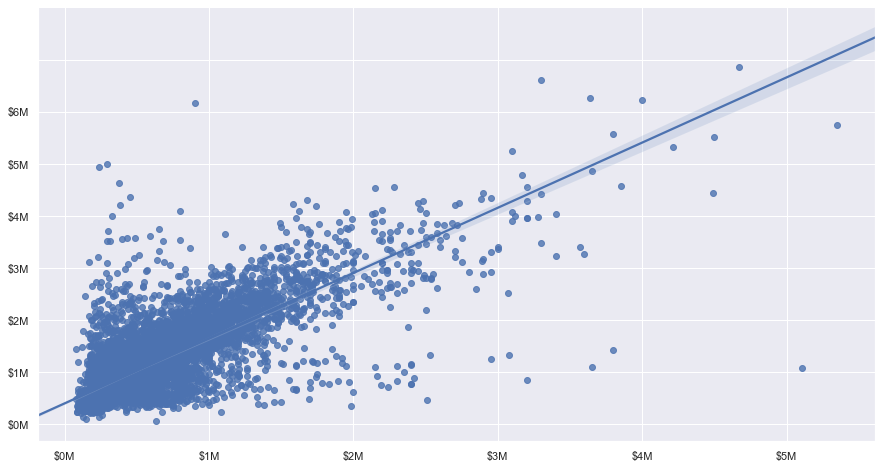

In [20]:
# sns regplot
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

mod = sns.regplot(x=y_train2, y=y_pred2);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in mod.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in mod.get_xticks()/1000000]
mod.set_xticklabels(xlabels);
mod.set_yticklabels(ylabels);